# Entrega 2
La entrega pasada nos enfocamos en realizar una primera aproximación. Ahora, a no ser que se trabaje con Deep Learning, para hacer un trabajo de clasificación, es necesario tener 2 elementos principales: 
>un descriptor \
>un clasificador

El primero, tal como su nombre lo indica, es el que nos va a permitir describir la imagen, es decir expresar sus características de forma cuantitativa para poder tomar decisiones sobre esta, ese es el vector de TM que hicimos en la entrega pasada. El segundo, cuyo nombre también nos da una pista de su utilidad, sirve para tomar las características que nos da el descriptor y poder asignar clases a las imágenes basándonos en estas. En esta entrega nos enfocaremos en la realización de los descriptores de patrones visuales que hemos visto en la magistral usando como clasificador el vecino mas cercano que hicimos el laboratorio pasado.

## Parte 1: Modificaciones al vecino mas cercano
Lo primero que vamos a hacer será modificar nuestra clase del vecino mas cercano que hicimos la entrega pasada. Esto es debido a que en la entrega pasada en el interior de la funcion tanto de entrenamiento como de predicción se calculaban los descriptores. Sin embargo haremos unas modificaciones a este metodo con el fin de que no se tengan que calcular los descriptores cada vez que se quiera clasificar. 
> **Nota**: los cambios que tienen que hacer a sus codigos son minimos, unicamente es eliminar la linea que calculaba el descriptor y asumir que X es directamente el descriptor


In [1]:
class NN_classifier:
    def __init__(self):
        '''
        :param descriptor (dict): Diccionario de templates de entrenamiento.
        '''
        self.vectores='' #atributo del vector de descriptores de entrenamiento
        self.etiquetas='' #atributo del vector de etiquetas
        # YOUR CODE HERE
        self.vectores = []
        self.etiquetas = []
        
    def fit(self,X,y):
        '''
        :param X: Imagenes de entrenamiento
        :param y: Labels de las imagenes
        :return: self (Trained descriptor)
        '''
        # YOUR CODE HERE
        for imagen, etiqueta in zip(X,y):
            self.vectores.append(imagen)
            self.etiquetas.append(etiqueta)
        return self
    
    def predict(self,X):
        '''
        :param X (array): Imagenes a predecir
        :return: Arreglo de etiquetas predichas
        '''
        # No se reciben imagenes sino los descriptores de las imagenes
        # YOUR CODE HERE
        etiqueta = np.zeros(len(X))
        for n, imagen in enumerate(X):
            # primero hallar el descriptor de la imagen
            descriptor_imagen = imagen
            # encontrar el minimo de distancia                
            distancia_minima = np.inf
            etiqueta_minima = None
            for j, train_vector in enumerate(self.vectores):
                # calculo de distancia
                distancia = np.linalg.norm(train_vector - descriptor_imagen)
                # actualizacion en caso de ser la menor distancia
                if distancia < distancia_minima:
                    distancia_minima = distancia
                    etiqueta[n] = self.etiquetas[j]
        return etiqueta


## Parte 2: Textura
Una de las formas en las que se puede hacer una descripción de la textura de una imagen es mediante el histograma de textones, el cual es una forma de cuantificar la presencia de las textura existentes. Para esto, debemos implementar una función que calcule dicho histograma utilizando un diccionario de textones. Por lo anterior, implementaremos tres funciones auxiliares que nos permitirán obtener sus descriptores de textura. Estas funciones deben realizarlas para poder calcular la respuesta a los filtros, calcular el diccionario de textones y calcular el histograma de textones.

Primeramente vamos a sacar los filtros de interes, los cuales están en el archivo filterbank.mat


C:\Users\eduar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


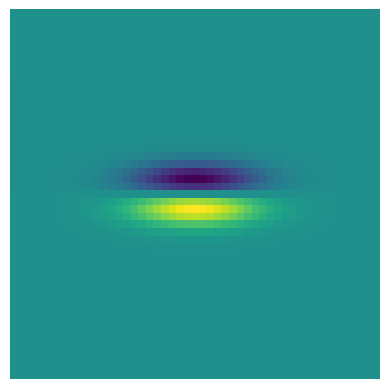

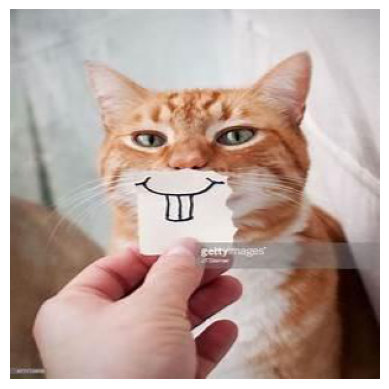

In [2]:
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
from skimage import io
from scipy.io import loadmat


filterbank = '' #Variable que contendrá los filtros para realizar los textones
image = '' #Variable que contendrá una imagen a color para probar las funciones

# YOUR CODE HERE
filterbank = loadmat('filterbank.mat')['filterbank']
filtro_1 = filterbank[:,:,0]
plt.imshow(filtro_1)
plt.axis('off')
plt.show()

image = cv2.resize(io.imread(os.path.join('Dataset','Test','Gato','31.jpeg')), (300,300))
plt.imshow(image)
plt.axis('off')
plt.show()

In [3]:
import numpy as np
assert not type(filterbank) == dict, f'su banco debería ser una matriz, no un diccionario, revise los elementos y busque el de interes'
print(f'la forma del banco de filtros es: {filterbank.shape}')
assert filterbank.shape == (49,49,18), f'su banco de filtros debería ser de tamaño (49,49,18), no {filterbank.shape}'

la forma del banco de filtros es: (49, 49, 18)


### 2.1 calcular la respuesta a los filtros
Esta primera función tiene como propósito hacer el cálculo de las respuestas a los filtros. Como podrán recordar de lo visto en la magistral, el primer paso para obtener sus textones, así como el mapa de textones de una imagen, es calcular la respuesta de la imagen en escala de grises a cada uno de los filtros que se encuentren en el banco. Finalmente, deben almacenar la respuesta a los filtros de cada uno de los píxeles de la imagen. 
> **Nota**: recuerde que el procedimiento debe ser hecho en escala de grises. Además, vamos a querer que cada pixel sea un dato, por lo que no usaremos una matriz de descriptores sino una lista de ellos.

In [4]:
from skimage.color import rgb2gray 
from skimage.feature import match_template

def calculate_filter_response(img, filters):
    '''
    :param img: imagen a color de la cual se va a calcular la respuesta a los filtros
    :param filters: filtros que serán usados
    '''
    
    # se convierte la imagen a escala de grises
    img = rgb2gray(img)
    
    # se calcula la cantidad de filtros (19)
    num_filters = filters.shape[2]
    
    # se crea el vector de respuesta de dimensiones (W*H, N)
    flattened_response = np.empty((img.shape[0]*img.shape[1], num_filters))

    # por cada filtro se calcula la respuesta y se agrega al vector
    for i in range(num_filters):
        filter_response = match_template(img, filters[:,:,i], pad_input=True)
        flattened_response[:, i] = filter_response.ravel()

    return flattened_response


In [5]:
pixel_response = calculate_filter_response(image,filterbank)
assert len(pixel_response.shape) == 2, f'la respuesta al filtro deberia tener 2 dimensiones, no {len(pixel_response.shape)}'
assert pixel_response.shape == (image.shape[0]*image.shape[1],18),f'la respuesta debería ser de tamaño {(image.shape[0]*image.shape[1],18)} no {pixel_response.shape}'

### 2.2 Calcular el diccionario de textones
Esta segunda función tiene como propósito construir un diccionario de textones. Esta deberá recibir por parámetro el arreglo de píxeles descritos por sus respuestas a los filtros (en las imágenes de entrenamiento). Luego, haciendo uso de un algoritmo de clusterización (comúnmente k-means), agruparlos en lo que serán "tipos de textura". Por último, los centroides de los clusters de textura generados, los cuales serán nuestros textones, deberán ser retornados.

In [6]:
from sklearn.cluster import KMeans

def calculate_texton_dictionary(pixels,n_textons):
    '''
    :param img:
    :param filters:
    '''
    # YOUR CODE HERE
    centroids = KMeans(n_clusters=n_textons, n_init=10).fit(pixels)
    return centroids # este debe el modelo KMeans

In [7]:
texton_dictionary = calculate_texton_dictionary(pixel_response,10)
try:
    texton_dictionary.n_features_in_
except:
    assert False,f'Su modelo no fue entrenado'
assert texton_dictionary.n_features_in_ == 18,f'su modelo tiene un espacio de {texton_dictionary.n_features_in_} dimensiones, no 18 como debería'
assert len(texton_dictionary.labels_)==image.shape[0]*image.shape[1],f'su modelo tiene {len(texton_dictionary.labels_)} puntos, no {image.shape[0]*image.shape[1]}'
assert len(texton_dictionary.cluster_centers_)==10,f'su modelo KMeans fue entrenado con {len(texton_dictionary.cluster_centers_)} clusters, no 10'

### 2.3 Calular histograma de textones
Esta última función generará el mapa de textones de una imagen, en base al cual obtendrán como respuesta el histograma de textones asociado. Esta deberá recibir por parámetro el arreglo de píxeles de la imagen a describir (la respuestas a los filtros) y asociar cada píxel a la etiqueta del centroide (textón) del cluster correspondiente, para finalmente construir y retornar el histograma de textones.
> **nota**: recuerde normalizar el histograma. Y recuerde que aqui tiene un numero finito de valores completos, por lo que debe tener un bin por cada valor

In [8]:
def calculate_texton_histogram(pixels,textons):
    '''
    :param pixels: Array de respuesta a los filtros de la imagen 
    :param texton_dictionary: diccionario de textones(Modelo KMeans)
    '''
    # YOUR CODE HERE
    n_clusters = textons.cluster_centers_.shape[0]
    labels = textons.predict(pixels)
    #texton_histogram, _ = np.histogram(labels, bins=np.arange(n_clusters + 1), density=True)
    texton_histogram, _ = np.histogram(labels, bins=n_clusters)
    texton_histogram = texton_histogram / np.sum(texton_histogram)
    return texton_histogram 

In [9]:
demo_hist = calculate_texton_histogram(pixel_response,texton_dictionary)
assert len(demo_hist)==10, f'el histograma debería tener 10 bins, uno por centroide, no {len(demo_hist)}'
assert np.isclose(np.sum(demo_hist),1,0.05), f'la suma del histogtama debería ser 1, no {np.sum(demo_hist)}'

Este es el unico descriptor que tendremos que entrenar, ya que los demás no dependen sino de las caracteristicas propias de la imagen. Por ello deben recalcular el diccionario de textones usando almenos 1 imagen de cada clase. 

In [10]:
texton_dictionary = '' #Variable que tendrá el diccionario de textones a usar. Usen uno de 10 textones como en el ejemplo

In [11]:
image_gato = cv2.resize(io.imread(glob(os.path.join('Dataset','Test','Gato','*.jpeg'))[0]), (300,300))
image_perro = cv2.resize(io.imread(glob(os.path.join('Dataset','Test','Perro','*.jpeg'))[0]), (300,300))
image_elefante = cv2.resize(io.imread(glob(os.path.join('Dataset','Test','Elefante','*.jpeg'))[0]), (300,300))
image_oveja = cv2.resize(io.imread(glob(os.path.join('Dataset','Test','Oveja','*.jpeg'))[0]), (300,300))
image_caballo = cv2.resize(io.imread(glob(os.path.join('Dataset','Test','Caballo','*.jpeg'))[0]), (300,300))

pixel_response_global = np.concatenate((calculate_filter_response(image_gato,filterbank), 
                               calculate_filter_response(image_perro,filterbank),
                               calculate_filter_response(image_elefante,filterbank),
                               calculate_filter_response(image_oveja,filterbank),
                               calculate_filter_response(image_caballo,filterbank))) 

texton_dictionary = calculate_texton_dictionary(pixel_response_global,10)

### 2.4 Funcion de calculo de descriptores 
Como ya fue mencionado, haciendo uso de las funciones previamente mencionadas y el/los diccionarios de textones que han generado y almacenado, deberán construir una función que genere el descriptor de textura. Un punto importante que deben tener en cuenta es que usarán esta función no solo para calcular los descriptores, sino para almacenarlos. La razón de esto es que los descriptores en algunos casos pueden tardar un tiempo considerable en ser calculados. Debido a lo anterior, sería computacionalmente costoso y tomaría tiempo en exceso hacer el cálculo de los descriptores en cada una de las entregas. El archivo que deben almacenar debe contener dos listas las cuáles tengan posiciones correspondientes entre ellas, una con la información de los descriptores (uno por imagen) y la otra con la anotación correspondiente. La función debe tener la siguiente estructura:

In [12]:
def texture(images, labels, route, textons):
    '''
    :param images: Imágenes de la cuales se calculará el descriptor.
    :param labels: Etiquetas de las imágenes.
    :param route: Ruta donde serán guardados los descriptores junto con las etiquetas.
    :param textons: Diccionario de textones o ruta al archivo que lo contiene.
    :return features: Arreglo de etiquetas predichas con los descriptores de las imágenes (el mismo que se almacenará en route)
    '''
    # YOUR CODE HERE
    features = []
    
    for image in images:
        # calcular descriptor (se usa textones)
        pixel_response = calculate_filter_response(image,filterbank)
        hist = calculate_texton_histogram(pixel_response,textons)
        #guardar descriptor en features 
        features.append(hist)
        
    # guardar features y labels en route
    # se usa un diccionario para claridad
    data = {'descriptors': features, 'labels': labels}
    with open(route, 'wb') as f:
        np.save(f, data)
        
    return np.array(features)

In [13]:
train_images = '' #vector de imagenes de entrenamiento
train_annots = '' #vector de anotaciones de entrenamiento
train_texture_route = '' #ruta donde quieren guardar sus descriptores y labels

# YOUR CODE HERE

def load_images(nombre_carpeta, nombre_clase, cantidad=10):
    paths = np.random.choice(glob(os.path.join('Dataset', nombre_carpeta, nombre_clase,'*.jpeg')),size=cantidad,replace=False)
    imgs = np.array([cv2.resize(cv2.imread(path),(300,300)) for path in paths])
    return imgs

def load_images_global(nombre_carpeta, cantidad=10):
    # se obtienen 10 imagenes de train de cada clase
    imgs_gato = load_images(nombre_carpeta,'Gato', cantidad)
    imgs_perro = load_images(nombre_carpeta,'Perro', cantidad)
    imgs_elefante = load_images(nombre_carpeta,'Elefante', cantidad)
    imgs_oveja = load_images(nombre_carpeta,'Oveja', cantidad)
    imgs_caballo = load_images(nombre_carpeta,'Caballo', cantidad)
    
    # se obtiene el vector de imagenes de la carpeta
    images = np.concatenate((imgs_gato, imgs_perro, imgs_elefante, imgs_oveja, imgs_caballo))

    # se obtiene el vector de anotaciones de train
    dict_etiquetas = dict(zip(['gato','perro','elefante','oveja','caballo'],[1,2,3,4,5]))
    annots = [dict_etiquetas['gato']]*cantidad + [dict_etiquetas['perro']]*cantidad + [dict_etiquetas['elefante']]*cantidad + [dict_etiquetas['oveja']]*cantidad + [dict_etiquetas['caballo']]*cantidad
    
    return images, annots

train_images, train_annots = load_images_global('Train', 10)
# se define la ruta
train_texture_route = os.path.join('train_texture.npy')

In [14]:
import os
texture_desc = texture(train_images,train_annots,train_texture_route,texton_dictionary)
assert len(texture_desc.shape) == 2 ,f'Su vector de descriptores debe tener 2 dimensiones, no len(texture_desc.shape)'
assert texture_desc.shape[0] == len(train_images),f'no existe un decriptor por imagen, hay {texture_desc.shape[0]} descriptores y {len(train_images)} imagenes'
assert not np.isclose(np.std(texture_desc),0,0.001),f'su funcion retorna descriptores similares o identicos'
assert os.path.isfile(train_texture_route),'no se está guardando el archivo'

assert texture_desc.shape[1] ==10,f'su modelo KMeans fue entrenado con {len(texton_dictionary.cluster_centers_)} clusters, no 10'

## Parte 3: Color
Lo primero que se debe realizar, como ya se dijo, es el descriptor mediante el cual vamos a representar una imagen en un vector. En esta entrega se trabajará únicamente con descriptores basados en color. Estos, se basan en representar la imagen según los diferentes colores que la compongan mediante el uso de histogramas, ya que pretende caracterizar la frecuencia de cada una de las intensidades de los colores.

Este descriptor de histogramas de color será el primero que usaremos. La función debe tener la capacidad de calcular tanto histogramas de color conjuntos como histogramas de color concatenados los cuáles pueden obtenerlos utilizando las funciones ```CatColorHistogram``` y ```JointColorHistogram``` que se encuentran a continuación. Además, debe poder utilizar diferentes canales de color como ```rgb```, ```hsv``` y ```lab```. 

In [15]:
# Functions for color histograms

def CatColorHistogram(img, num_bins, min_val=None, max_val=None):
    """
    Calculate concatenated histogram for color images
    By: Natalia Valderrama built on Maria Fernanda Roa's code
    
    Arguments: img (numpy.array) -- 2D color image
    num_bins (array like of ints) -- Number of bins per channel.
    If an int is given, all channels will have same amount of bins.

    Keyword Arguments:
    min_val (array like of ints) -- Minimum intensity range value per channel
    If an int is given, all channels will have same minimum. (default: {None})
    max_val (array like of ints) -- Maximum intensity range value per channel
    If an int is given, all channels will have same maximum. (default: {None})

    Returns: [numpy.array] -- Array containing concatenated color histogram of size num_bins*3.
    """
    assert len(img.shape) == 3, 'img must be a color 2D image'

    #Transform image to float dtype
    img = img_as_float(img)
    _, _, n_channels = img.shape

    #Verify input parameters
    assert isinstance(num_bins, (int, tuple, list, np.array)),'num_bins must be int or array like'

    if isinstance(num_bins, int):
        num_bins = np.array([num_bins]*n_channels)
    else:
        num_bins = np.array(num_bins)

    assert len(num_bins) == n_channels,'num_bins length and number of channels differ'
 
    if min_val is None:
        min_val = np.min(img, (0,1))
    else:
        assert isinstance(min_val, (int, tuple, list, np.array)),'min_val must be int or array like'
        if isinstance(min_val, int):
            min_val = np.array([min_val]*n_channels)
        else:
            min_val = np.array(min_val)

    assert len(min_val) == n_channels,'min_val length and number of channels differ'
    
    min_val = min_val.reshape((1, 1, -1))

    if max_val is None:
        max_val = np.max(img, (0,1))
    else:
        assert isinstance(max_val, (int, tuple, list, np.array)),'max_val must be int or array like'
        if isinstance(max_val, int):
            max_val = np.array([max_val]*n_channels)
        else:
            max_val = np.array(max_val)

    assert len(max_val) == n_channels,'max_val length and number of channels differ'
    max_val = max_val.reshape((1, 1, -1)) + 1e-5
    concat_hist = np.zeros(np.sum(num_bins), dtype=int)
    # Scale intensities (intensities are scaled within the range for each channel)
    # Values now are between 0 and 1
    img = (img - min_val) / (max_val - min_val)
    sum_value = 0

    for c in range(n_channels):
        # Calculate index matrix for each channel

        idx_matrix = np.floor(img[...,c]*num_bins[c]).astype('int')
        idx_matrix = idx_matrix.flatten() + sum_value
        sum_value += num_bins[c]
        
        #Create concatenated histogram
        for p in range(len(idx_matrix)):
            concat_hist[idx_matrix[p]] += 1
    
    return concat_hist/np.sum(concat_hist)

def JointColorHistogram(img, num_bins, min_val=None, max_val=None):
    """
    Calculate joint histogram for color images
    By: Maria Fernanda Roa

    Arguments: img (numpy.array) -- 2D color image
    num_bins (array like of ints) -- Number of bins per channel.
    If an int is given, all channels will have same amount of bins.

    Keyword Arguments:
    min_val (array like of ints) -- Minimum intensity range value per channel
    If an int is given, all channels will have same minimum. (default: {None})
    max_val (array like of ints) -- Maximum intensity range value per channel
    If an int is given, all channels will have same maximum. (default: {None})

    Returns: [numpy.array] -- Array containing joint color histogram of size num_bins.
    """

    assert len(img.shape) == 3, 'img must be a color 2D image'

    #Transform image to float dtype
    img = img_as_float(img)
    _, _, n_channels = img.shape

    #Verify input parameters
    assert isinstance(num_bins, (int, tuple, list, np.array)),'num_bins must be int or array like'

    if isinstance(num_bins, int):
        num_bins = np.array([num_bins]*n_channels)
    else:
        num_bins = np.array(num_bins)

    assert len(num_bins) == n_channels,'num_bins length and number of channels differ'
 
    if min_val is None:
        min_val = np.min(img, (0,1))
    else:
        assert isinstance(min_val, (int, tuple, list, np.array)),'min_val must be int or array like'
        if isinstance(min_val, int):
            min_val = np.array([min_val]*n_channels)
        else:
            min_val = np.array(min_val)

    assert len(min_val) == n_channels,'min_val length and number of channels differ'
    
    min_val = min_val.reshape((1, 1, -1))

    if max_val is None:
        max_val = np.max(img, (0,1))
    else:
        assert isinstance(max_val, (int, tuple, list, np.array)),'max_val must be int or array like'
        if isinstance(max_val, int):
            max_val = np.array([max_val]*n_channels)
        else:
            max_val = np.array(max_val)

    assert len(max_val) == n_channels,'max_val length and number of channels differ'
    max_val = max_val.reshape((1, 1, -1)) + 1e-5

    joint_hist = np.zeros(num_bins, dtype=int)
    num_bins = num_bins.reshape((1, 1, -1))

    # Scale intensities (intensities are scaled within the range for each channel)
    # Values now are between 0 and 1
    img = (img - min_val) / (max_val - min_val)

    # Calculate index matrix
    idx_matrix = np.floor(img*num_bins).astype('int')
    idx_matrix = idx_matrix.reshape((-1, n_channels))
    
    #Create joint histogram
    for p in range(len(idx_matrix)):
        joint_hist[tuple(idx_matrix[p, :])] += 1
        
    return joint_hist/np.sum(joint_hist)

In [16]:
from skimage.color import rgb2hsv, rgb2lab
from skimage import img_as_float

def color(images, labels, route, type, space_bins, color_space):
    '''
    :param images}: Lista con las imágenes (o rutas de las imágenes) a la cuales se les calculará el descriptor.
    :param labels: Lista con las etiquetas de las imágenes pasadas por parámetro.
    :param route: Ruta donde serán guardados los descriptores junto con las etiquetas.
    :param type: Parámetro que indica el tipo de histograma de color que se calculará, puede ser ``joint'' o ``concat''.
    :param space_bins: Número entero que indica el numero de bins que existirá por cada canal de color.
    :param color_space: Parámetro que indica el espacio de color que se usará, puede ser ``rgb'', ``hsv'', o ``lab''.
    
    :return features: Arreglo de etiquetas predichas con los descriptores de las imágenes (el mismo que se almacenará en route)
    '''
    # YOUR CODE HERE
    features = []
    
    for image in images:
        # se transforma al espacio de color
        if color_space == 'rgb':
            pass
        elif color_space == 'hsv':
            image = rgb2hsv(image)
        elif color_space == 'lab':
            image = rgb2lab(image)
        else:
            raise Exception('color_space no válido')
        # se calcula el histograma
        if type == 'joint':
            hist = JointColorHistogram(image, space_bins).flatten()
        elif type == 'concat':
            hist = CatColorHistogram(image, space_bins)
        else:
            raise Exception('type no válido')
        #print(hist.shape)
        # se agrega el histograma a features
        features.append(hist)
    
    # guardar features y labels en route
    # se usa un diccionario para claridad
    data = {'descriptors': features, 'labels': labels}
    with open(route, 'wb') as f:
        np.save(f, data)
    
    return np.array(features)

In [17]:
train_color_route = ''
# YOUR CODE HERE
train_color_route = os.path.join('train_color.npy')

In [18]:
import os
color_desc = color(train_images,train_annots,train_color_route,"joint",5,"rgb")
assert len(color_desc.shape) == 2 ,f'Su vector de descriptores debe tener 2 dimensiones, no {len(color_desc.shape)}'
assert color_desc.shape[0] == len(train_images),f'no existe un decriptor por imagen, hay {color_desc.shape[0]} descriptores y {len(train_images)} imagenes'
assert not np.isclose(np.std(color_desc),0,0.001),f'su funcion retorna descriptores similares o identicos'
assert os.path.isfile(train_color_route),'no se está guardando el archivo'

assert color_desc.shape[1] ==5**3,f'su modelo histograma conjunto tiene {color_desc.shape[1]} bins, no {5**3}'
color_desc_cat = color(train_images,train_annots,train_color_route,"concat",5,"rgb")
assert color_desc_cat.shape[1] ==5*3,f'su modelo histograma conjunto tiene {color_desc_cat.shape[1]} bins, no {5*3}'

## Parte 4: Forma
Finalmente, el último descriptor que utilizaremos en este miniproyecto será basado en forma, para esto usarán el {Histograma de gradientes orientados (HOG) que pueden encontrar en el siguiente link.

https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog. 

Este descriptor es especialmente importante ya que es el único descriptor de los que utilizaremos que tiene en cuenta la posición espacial. Para esto, deberán implementar una función que retorne el histograma de gradientes orientados. En esta, deben poder variar por parámetro 2 parámetros que ustedes establezcan para experimentar. Al igual que las funciones de los otros descriptores, esta función no solo debe retornar los descriptores de las imágenes sino que debe poder almacenarlos en un archivo local.  Esta función debe tener la siguiente estructura:\\

In [19]:
from skimage.feature import hog

def shape(images, labels, route, param1 = 3, param2 = 3):
    '''
    :param images: Imágenes de la cuales se calculará el descriptor.
    :param labels: Etiquetas de las imágenes.
    :param route: Ruta donde serán guardados los descriptores junto con las etiquetas.
    :param param1: Parámetro 1 que variarán para calcular HOG. Debe ser por defecto un valor por las pruebas
    :param param2: Parámetro 2 que variarán para calcular HOG.Debe ser por defecto un valor por las pruebas
    
    :return features: Arreglo de etiquetas predichas con los descriptores de las imágenes (el mismo que se almacenará en route)
    '''
    # YOUR CODE HERE
    features = []
    
    # param1 es orientaciones
    # param2 es pixeles por celda (siempre es cuadrada)
    
    for image in images:
        # se calcula el histograma
        hist = hog(image, orientations=param1, pixels_per_cell=(param2,param2), channel_axis=2)
        # se agrega el histograma a features
        features.append(hist)
    
    data = {'descriptors': features, 'labels': labels}
    with open(route, 'wb') as f:
        np.save(f, data)
    
    return np.array(features)

In [20]:
train_shape_route = ''
# YOUR CODE HERE
train_shape_route = os.path.join('train_shape.npy')

In [21]:
import os
shape_desc = shape(train_images,train_annots,train_shape_route)
assert len(shape_desc.shape) == 2 ,f'Su vector de descriptores debe tener 2 dimensiones, no {len(shape_desc.shape)}'
assert shape_desc.shape[0] == len(train_images),f'no existe un decriptor por imagen, hay {shape_desc.shape[0]} descriptores y {len(train_images)} imagenes'
assert not np.isclose(np.std(shape_desc),0,0.001),f'su funcion retorna descriptores similares o identicos'
assert os.path.isfile(train_shape_route),'no se está guardando el archivo'

## Parte 5: Experimentación
Ahora que ya tenemos implementados nuestros nuevos descriptores de patrones visuales vamos a experimentar con ellos, usando

### 5.1 Textura:
Deben realizar la experimentación variando el número de textones que hay en el diccionario (es decir el numero de bins del histograma). Deben construir por lo menos 4 diccionarios diferentes.**(4 experimentos)**

> Nota: La respuesta a los filtros solo deberían calcularla una vez, guarden esto en archivos y calculen los 4 diccionarios e histogramas usando estos.

### 5.2 Color:
Deben realizar la experimentación en grid 2x3, variando el tipo de histograma que se calcula y el espacio de color respectivamente. **(6 experimentos)**

### 5.3 Forma: 
Deben realizar la experimentación en grid 2x2(es decir las 4 combinaciones de 2 parametros con 2 valores cada uno) escogiendo 2 parámetros de la función para calcular HOG y 2 valores para cada uno de dichos parámetros. **(4 experimentos)**



In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score

# 5. EXPERIMENTACIÓN

# VALIDACIÓN:

# 5.1. TEXTURA:

def get_pixel_responses(images, route):
    if os.path.exists(route) and os.path.getsize(route) > 0:
        #print('existe')
        with open(route, 'rb') as f:
            pixel_responses = np.load(f, allow_pickle=True)   
    else:
        #print('no existe')
        pixel_responses = []
        for image in images:
            pixel_responses.append( calculate_filter_response(image,filterbank) )
        with open(route, 'wb') as f:
            np.save(f, pixel_responses)
            
    return np.array(pixel_responses)

def texture_exp(images, labels, route, textons, responses):
    '''
    :param images: Imágenes de la cuales se calculará el descriptor.
    :param labels: Etiquetas de las imágenes.
    :param route: Ruta donde serán guardados los descriptores junto con las etiquetas.
    :param textons: Diccionario de textones o ruta al archivo que lo contiene.
    :return features: Arreglo de etiquetas predichas con los descriptores de las imágenes (el mismo que se almacenará en route)
    '''
    # YOUR CODE HERE
    features = []
    
    for i, image in enumerate(images):
        # calcular descriptor (se usa textones)
        pixel_response = responses[i]
        hist = calculate_texton_histogram(pixel_response,textons)
        #guardar descriptor en features 
        features.append(hist)
        
    # guardar features y labels en route
    # se usa un diccionario para claridad
    data = {'descriptors': features, 'labels': labels}
    with open(route, 'wb') as f:
        np.save(f, data)
        
    return np.array(features)


def experimento_texture(images, annots, num_textons, num_exp, 
                      carpeta:str, nombre_exp:str, stats=True):
    
    print(f'\nExperimento con textura #{num_exp}: {nombre_exp}')
    
    texton_dictionary = calculate_texton_dictionary(pixel_response_global, num_textons)
    
    # primero se calculan los descriptores de train
    train_texture_route = os.path.join(f'train_texture_{num_exp}.npy')
    texture_desc = texture_exp(train_images,train_annots,train_texture_route,texton_dictionary,pixel_responses)
    
    new_route = os.path.join(f'{carpeta}_texture_{num_exp}.npy')
    new_desc = texture(images,annots,new_route,texton_dictionary)
    
    model = NN_classifier()
    model.fit(texture_desc, annots)
    predictions = model.predict(new_desc)
    
    if stats:
        f1 = f1_score(annots, predictions, average='weighted')
        precision = precision_score(annots, predictions, average='weighted')
        cobertura = recall_score(annots, predictions, average='weighted')
        print(f'El f1 de {carpeta} del exp {nombre_exp} es {f1}')
        print(f'La precision de {carpeta} del exp {nombre_exp} es {precision}')
        print(f'La cobertura de {carpeta} del exp {nombre_exp} es {cobertura}')


# se obtienen sets de 250 imagenes de train
train_images, train_annots = load_images_global('Train', 50)
        
# se calcula la respuesta global
pixel_responses_route = os.path.join('pixel_responses.npy')    
pixel_responses = get_pixel_responses(train_images, pixel_responses_route)

# se obtienen sets de 250 imagenes de valid
valid_images, valid_annots = load_images_global('Valid', 50)


# EXP 1:
experimento_texture(valid_images, valid_annots, 3, 1, 'valid', '3 textones')

# EXP 2:
experimento_texture(valid_images, valid_annots, 7, 2, 'valid', '7 textones')

# EXP 3:
experimento_texture(valid_images, valid_annots, 13, 3, 'valid', '13 textones')

# EXP 4:
experimento_texture(valid_images, valid_annots, 17, 4, 'valid', '17 textones')


# se podría tomar una mayor muestra para pixel_response_global


Experimento con textura #1: 3 textones
El f1 de valid del exp 3 textones es 0.24471187165274544
La precision de valid del exp 3 textones es 0.24577848340833577
La cobertura de valid del exp 3 textones es 0.248

Experimento con textura #2: 7 textones
El f1 de valid del exp 7 textones es 0.2781957006139274
La precision de valid del exp 7 textones es 0.27915350700661107
La cobertura de valid del exp 7 textones es 0.288

Experimento con textura #3: 13 textones
El f1 de valid del exp 13 textones es 0.30822970111290526
La precision de valid del exp 13 textones es 0.3139285076743456
La cobertura de valid del exp 13 textones es 0.308

Experimento con textura #4: 17 textones
El f1 de valid del exp 17 textones es 0.22966530773014435
La precision de valid del exp 17 textones es 0.22860909919428993
La cobertura de valid del exp 17 textones es 0.236


In [23]:
# 5.2 COLOR

def experimento_color(images, annots, hist_type, space_bins, color_space, num_exp, 
                      carpeta:str, nombre_exp:str, stats=True):
    
    print(f'\nExperimento con color #{num_exp}: {nombre_exp}')
    
    # primero se calculan los descriptores de train
    train_color_route = os.path.join(f'train_color_{num_exp}.npy')
    color_desc = color(train_images,train_annots,train_color_route,hist_type,space_bins,color_space)
    
    new_route = os.path.join(f'{carpeta}_color_{num_exp}.npy')
    new_desc = color(images,annots,new_route,hist_type,space_bins,color_space)
    
    model = NN_classifier()
    model.fit(color_desc, annots)
    predictions = model.predict(new_desc)
    
    if stats:
        f1 = f1_score(annots, predictions, average='weighted')
        precision = precision_score(annots, predictions, average='weighted')
        cobertura = recall_score(annots, predictions, average='weighted')
        print(f'El f1 de {carpeta} del exp {nombre_exp} es {f1}')
        print(f'La precision de {carpeta} del exp {nombre_exp} es {precision}')
        print(f'La cobertura de {carpeta} del exp {nombre_exp} es {cobertura}')
    

# EXP 1:
experimento_color(valid_images,valid_annots,'joint',5,'rgb',1,'valid','joint+rgb')

# EXP 2:
experimento_color(valid_images,valid_annots,'joint',5,'hsv',2,'valid','joint+hsv')

# EXP 3:
experimento_color(valid_images,valid_annots,'joint',5,'lab',3,'valid','joint+lab')

# EXP 4:
experimento_color(valid_images,valid_annots,'concat',5,'rgb',4,'valid','concat+rgb')

# EXP 5:
experimento_color(valid_images,valid_annots,'concat',5,'hsv',5,'valid','concat+hsv')

# EXP 6:
experimento_color(valid_images,valid_annots,'concat',5,'lab',6,'valid','concat+lab')


Experimento con color #1: joint+rgb
El f1 de valid del exp joint+rgb es 0.29357503746281416
La precision de valid del exp joint+rgb es 0.2939026349958647
La cobertura de valid del exp joint+rgb es 0.296

Experimento con color #2: joint+hsv
El f1 de valid del exp joint+hsv es 0.2829958345747819
La precision de valid del exp joint+hsv es 0.2850964576191436
La cobertura de valid del exp joint+hsv es 0.284

Experimento con color #3: joint+lab
El f1 de valid del exp joint+lab es 0.2878958378110564
La precision de valid del exp joint+lab es 0.2867690581242812
La cobertura de valid del exp joint+lab es 0.296

Experimento con color #4: concat+rgb
El f1 de valid del exp concat+rgb es 0.1886302993407047
La precision de valid del exp concat+rgb es 0.18988444095586954
La cobertura de valid del exp concat+rgb es 0.188

Experimento con color #5: concat+hsv
El f1 de valid del exp concat+hsv es 0.2847441190848078
La precision de valid del exp concat+hsv es 0.28652364302364297
La cobertura de valid de

In [24]:
# 5.3 FORMA

def experimento_shape(images, annots, param1, param2, num_exp, 
                      carpeta:str, nombre_exp:str, stats=True):
    
    print(f'\nExperimento con forma #{num_exp}: {nombre_exp}')
    
    # primero se calculan los descriptores de train
    train_shape_route = os.path.join(f'train_shape_{num_exp}.npy')
    shape_desc = shape(train_images,train_annots,train_shape_route,param1,param2)
    
    new_route = os.path.join(f'{carpeta}_shape_{num_exp}.npy')
    new_desc = shape(images,annots,new_route,param1,param2)
    
    model = NN_classifier()
    model.fit(shape_desc, annots)
    predictions = model.predict(new_desc)
    
    if stats:
        f1 = f1_score(annots, predictions, average='weighted')
        precision = precision_score(annots, predictions, average='weighted')
        cobertura = recall_score(annots, predictions, average='weighted')
        print(f'El f1 de {carpeta} del exp {nombre_exp} es {f1}')
        print(f'La precision de {carpeta} del exp {nombre_exp} es {precision}')
        print(f'La cobertura de {carpeta} del exp {nombre_exp} es {cobertura}')
        
        
# EXP 1:
experimento_shape(valid_images,valid_annots,13,10,1,'valid','anotaciones=13,pixeles_por_celda=10')

# EXP 2:
experimento_shape(valid_images,valid_annots,13,13,2,'valid','anotaciones=13,pixeles_por_celda=13')

# EXP 3:
experimento_shape(valid_images,valid_annots,10,13,3,'valid','anotaciones=10,pixeles_por_celda=13')

# EXP 4:
experimento_shape(valid_images,valid_annots,10,10,4,'valid','anotaciones=10,pixeles_por_celda=10')


Experimento con forma #1: anotaciones=13,pixeles_por_celda=10
El f1 de valid del exp anotaciones=13,pixeles_por_celda=10 es 0.17602112655819857
La precision de valid del exp anotaciones=13,pixeles_por_celda=10 es 0.31937643339738425
La cobertura de valid del exp anotaciones=13,pixeles_por_celda=10 es 0.224

Experimento con forma #2: anotaciones=13,pixeles_por_celda=13
El f1 de valid del exp anotaciones=13,pixeles_por_celda=13 es 0.18786032069030142
La precision de valid del exp anotaciones=13,pixeles_por_celda=13 es 0.3773839430671012
La cobertura de valid del exp anotaciones=13,pixeles_por_celda=13 es 0.236

Experimento con forma #3: anotaciones=10,pixeles_por_celda=13
El f1 de valid del exp anotaciones=10,pixeles_por_celda=13 es 0.18404152813818744
La precision de valid del exp anotaciones=10,pixeles_por_celda=13 es 0.3375396825396826
La cobertura de valid del exp anotaciones=10,pixeles_por_celda=13 es 0.232

Experimento con forma #4: anotaciones=10,pixeles_por_celda=10
El f1 de val

In [25]:
# TEST

print('Se elige el mejor modelo y se hace prueba con el dataset de test')

test_images, test_annots = load_images_global('Test', 50)

experimento_color(test_images,test_annots,'joint',5,'rgb',1,'test','joint+rgb')

Se elige el mejor modelo y se hace prueba con el dataset de test

Experimento con color #1: joint+rgb
El f1 de test del exp joint+rgb es 0.26717633887668557
La precision de test del exp joint+rgb es 0.2696649927315977
La cobertura de test del exp joint+rgb es 0.268


## Articulo

Una vez realizado el procedimiento es fundamental que se continue con la construcción del articulo de forma progresiva, por lo cual incluiremos lo que hicimos en esta entrega.

### Abordaje

#### Descriptores
Inicialmente explicarán los descriptores, estos no solo los usarán para su método de baseline, sino para el método final. Para esta entrega, describan los 3 descriptores, además de los parámetros que variaron y su propósito. Para esta descripción pueden basarse en las siguientes preguntas:
- ¿En qué consistía su descriptor?
- ¿Qué pretendía mostrar?
- ¿Qué características de la imagen usa?
- ¿Por qué este descriptor sería de utilidad?

#### Baseline
Paso siguiente, deben describir su método de vecino mas cercano, el cual será su *baseline* con el que deberán compararse al tener su metodología experimental.
Para esto describan brevemente el procedimiento que usaron para poder asignar etiquetas basados en clusterización. No incluyan información sobre la librería o la función específica, basta con el método, parámetros y describir su razonamiento. Pueden guiarse de las siguientes preguntas:

- ¿En qué consiste su método?
- ¿De qué elementos y procedimientos se compone?
- ¿Qué ventajas tiene?
- ¿Por qué este clasificador sería de utilidad?

Registren los resultados de sus experimentos del clasificador de *baseline* en su artículo. Incluyan los resultados en una única tabla y resalten en negrilla su mejor resultado, además realice una breve descripción de estos resultados.


### Experimentos
#### Baseline
Finalmente, ya cuentan con los primeros experimentos así como sus primeros resultados, los cuáles deberán ser agregados a su artículo en la sección de experimentos. Primero hagan la descripción de los experimentos que realizaron para los descriptores de color. Luego, incluyan los resultados de la experimentación en una única tabla y señalen en negrilla claramente cuál fue el mejor resultado. Además, deben hacer una breve descripción de sus resultados. Para lo anterior, pueden usar las siguientes preguntas como guía para armar su descripción.
- ¿Cuál fue su mejor método?
- ¿Hubo algún parámetro que influyera mas? (i.e. el histograma conjunto tuvo mejor desempeño en términos generales que el concatenado.)
- ¿Qué combinación no funcionó de forma correcta?
- ¿Existía alguna tendencia?}

### Discusión

#### Descriptores
Incluyan un análisis de lo obtenido en sus experimentos. Para esto analicen las implicaciones que tienen las métricas obtenidas en los resultados así como los resultados cualitativos, teoricen sobre las razones detrás de estos resultados y cómo propondrían mejorar estas falencias.

#### Baseline
Además, deben discutir sobre el método final que obtuvieron para el baseline (NN con su mejor descriptor) y los resultados de la experimentación que los condujeron a esta decisión, analicen las métricas y resultados cualitativos que lograron obtener.
Para la discusión pueden utilizar las siguientes preguntas como guía: 
- ¿Por qué creen que el mejor experimento dio así?
- Si existe alguna tendencia ¿qué podría significar esta?
- ¿Se debe continuar con el descriptor de mejor desempeño?
- ¿Cuál de los descriptores cree usted que obtendrá mejores resultados con los clasificadores supervisados? ¿Por qué?
- ¿Cree usted que su método de \textit{baseline} es óptimo? ¿Que ventajas/dificultades tiene?
- ¿Qué características comunes tienen aquellas imágenes mal clasificadas?

In [26]:
from utils import *

converter("Entrega 2")